In [1]:
import pandas as pd
import numpy as np
import math
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox

In [2]:
device = torch.device('cuda')

In [3]:
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
class RAFDBDataset(Dataset):
    """RAF-DB Dataset"""
    def __init__(self, file_path, img_path, split = 'train', transform=None):
        """
        Args:
            file_path (string): Path to the RAFDB txt file.
        """
        self.file_path = file_path
#         self.classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        self.labels = [t.rstrip().split() for t in open('list_patition_label.txt', 'r').readlines()]
        self.labels = np.array([[t[0][:-4]+"_aligned"+t[0][-4:], t[1]] for t in self.labels])
        
        index = np.random.permutation(len(self.labels))
        self.labels = self.labels[index]
        if split == 'train':
            self.labels = self.labels[:12000]
        elif split == 'valid':
            self.labels = self.labels[12000:]
        self.loader = pil_loader
        self.transform = transform
        self.img_path = img_path
        
    def __len__(self):  # dataset size
        return len(self.labels)
    
    def __getitem__(self, idx): # to return image and emotion when call `dataset[idx]`
        data = self.labels[idx]
        img = self.loader(self.img_path + data[0])
        label = int(data[1]) -1
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [5]:
validset = RAFDBDataset('list_patition_label.txt', 'rafdb/aligned/', split = 'valid', transform=transforms.ToTensor())
validloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False, num_workers=0)

In [6]:
net = torch.load('rafdb_resnet18.pth', map_location=device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# put a model forward hook to collect the feature for each image

fc_collector = list()
def collect():
    def get_output(self, input, output):
        fc_collector.append(output.cpu())
    return get_output
net.avgpool.register_forward_hook(collect())

In [8]:
# test

pbar = tqdm(validloader, desc='Test')
y = list()
y_hat = list()
with torch.no_grad():
    for batch_idx, (image, label) in enumerate(pbar):
        image = image.to(device)
        y.append(label.item())
        output = net.forward(image)
        _, predicted = torch.max(output.data, 1)
        y_hat.append(predicted.item())       

Test: 100%|████████████████████████████████████████████████████████████████████████| 3339/3339 [02:22<00:00, 23.38it/s]


In [9]:
fc_collector = torch.cat(fc_collector)
fc_collector.shape

torch.Size([3339, 512, 1, 1])

In [10]:
fc_collector = fc_collector.view(fc_collector.shape[:2])
fc_collector.shape

torch.Size([3339, 512])

In [11]:
pca = PCA(n_components=2).fit_transform(fc_collector)

,pca_1,pca_2,output
0,-3.175790,-3.486252,2
1,-2.967001,-0.041511,2
2,-2.783998,-4.534264,6
3,-4.129514,-2.644888,0
4,3.969331,2.056171,3
...,...,...,...
3334,-2.641665,-0.297274,5
3335,3.131951,0.149856,3
3336,6.997482,0.387136,3
3337,-2.361923,-5.919837,6


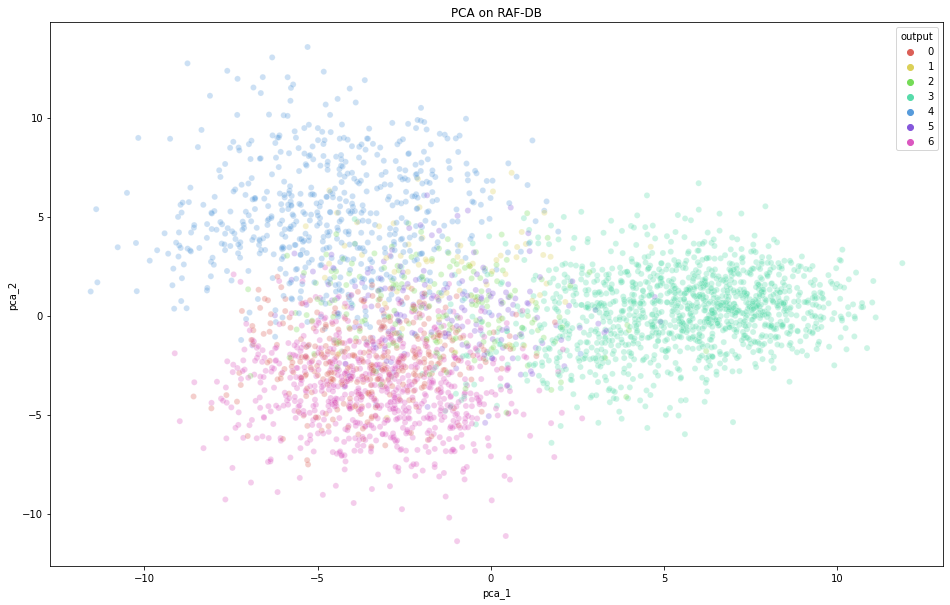

In [12]:
df = pd.DataFrame()
df['pca_1'] = pca[:, 0]
df['pca_2'] = pca[:, 1]
df['output'] = y
display(df)
plt.figure(figsize=(16,10))
plt.title(f'PCA on RAF-DB')
sns.scatterplot(
    x="pca_1", y="pca_2",
    hue="output",
    palette=sns.color_palette('hls', df['output'].nunique()),
    data=df.sample(frac=1),
    legend="full",
    alpha=0.3
)
plt.show()

In [13]:
tsne = TSNE(n_components=2).fit_transform(fc_collector)

,tsne_1,tsne_2,output
0,6.598089,-9.582952,2
1,5.767198,-9.460481,2
2,9.788052,4.456857,6
3,48.238590,-1.756276,0
4,-31.901596,0.011365,3
...,...,...,...
3334,24.820744,-31.142820,5
3335,-4.582062,-27.877470,3
3336,-15.414328,-26.446859,3
3337,30.574476,5.294260,6


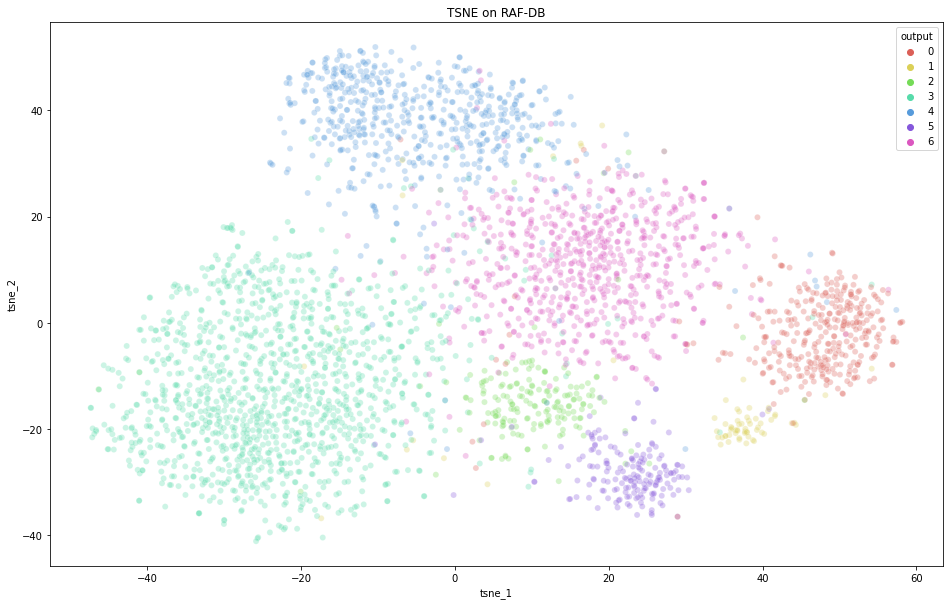

In [14]:
df = pd.DataFrame()
df['tsne_1'] = tsne[:, 0]
df['tsne_2'] = tsne[:, 1]
df['output'] = y
display(df)
plt.figure(figsize=(16,10))
plt.title(f'TSNE on RAF-DB')
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="output",
    palette=sns.color_palette('hls', df['output'].nunique()),
    data=df.sample(frac=1),
    legend="full",
    alpha=0.3
)
plt.show()